# Introduction

This notebook serves to replicate Oliver's results with his tensorflow model on a dataset with zero overlap conditions. We'll be testing the simplified version of the model where there are zero overlaps.

In [1]:
import os

#Change working directory to /Users/albertvong/Documents/Argonne/PtychoPINN/
os.chdir('/home/av_linux/PtychoPINN')
import numpy as np
import importlib

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from tensordict import TensorDict, TensorDictBase

import lightning as L
import mlflow.pytorch
from mlflow import MlflowClient

from ptycho_torch.dset_loader_pt_mmap import PtychoDataset
from ptycho_torch.model import PtychoPINN
import ptycho_torch.helper as hh

import matplotlib.pyplot as plt



/root/miniconda3/envs/ptychopinn_ptychodus_pytorch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We're going to try MAE loss first just to take the Poisson scaling out of the equation.

In [2]:
from ptycho_torch.config_params import TrainingConfig, DataConfig, ModelConfig

data_config_default = {
    'nphotons': 1e5,
    'N': 64,
    'C': 4,
    'K': 6,
    'n_subsample': 10,
    'grid_size': (2,2),
    'probe_dir_get': True,
    'normalize': False
}


model_config_default = {
    'intensity_scale_trainable': True,
    'max_position_jitter': 10, #Random jitter for translation (helps make model more robust)
    'n_filters_scale': 2, #Shrinking factor for channels
    'intensity_scale': 10000.0, #General intensity scale guess, this can be trainable. Needs to be float
    'object.big': False, #True if need patch reassembly
    'probe.big': False, #True if need patch reassembly
    'offset': 4,
    'loss_function': 'MAE'
}

training_config_default = {
    'nll': True, #Negative log likelihood for loss function
    'device': 'cuda'
}

t_config, d_config, m_config = TrainingConfig(), DataConfig(), ModelConfig()

t_config.set_settings(training_config_default)
d_config.set_settings(data_config_default)
m_config.set_settings(model_config_default)

# Modifying Oliver's Dataset

We're going to create an artifical dataset from "lines_no_overlap.npz". 

We technically only need X (diffraction stack) and probe (probe), but we'll also get dummy coordinates for the fields xcoords, ycoords, xcoords_start and ycoords_start which are typically required by the dataloader

In [ ]:
test = np.load('ptycho_torch/datasets/lines_no_overlap.npz')
test.files

Originally, the shape of the diffraction images is channel last, so we need to transpose it to the second dimension.

Also, the probe has a dummy empty third dimension, so we squeeze to remove it

In [ ]:
np.savez('ptycho_torch/datasets/lines_no_overlap_diff/lines_modified.npz',
        diff3d = test['X'].squeeze())

np.savez('ptycho_torch/datasets/probes_lines/probe1.npz',
        probe = test['probe'].squeeze())

# Constructing the dataset/dataloaders

The datasets in question are located as follows:

1. Diffraction stack: ptycho_torch/datasets/lines_no_overlap_diff
2. Probe: ptycho_torch/datasets/probes_lines

In [3]:
from ptycho_torch.dset_loader_pt_mmap import TensorDictDataLoader

In [4]:
test_dset = PtychoDataset('ptycho_torch/datasets/lines_no_overlap_diff',
                          'ptycho_torch/datasets/probes_lines',
                          remake_map = True)

['probe1.npz']
Creating memory mapped tensor dictionary...
Memory map length: 13778
Memory map creation time: 0.00603175163269043
Populating memory map for dataset 0
Non-diffraction memory map write time: 0.002779245376586914
Diffraction memory map write time: 4.02532434463501


In [5]:
testloader = TensorDictDataLoader(test_dset, batch_size = 64)

In [6]:
test_iter = next(iter(testloader))

# Training

Here, we just call train.py in the main directory. I'll fix this up in the future so we can call train.py within the notebook.

# Evaluating model afterwards

Here we'll import the model based on run-id and see the quality of some reconstructions

In [7]:
run_id = '6ac38aa353974faaa5a6649a2d80a358'
loaded_model = mlflow.pytorch.load_model(f"ptycho_torch/mlruns/677144611495216527/{run_id}/artifacts/model")

In [8]:
diff = test_iter[0]['images'].to('cuda')
positions = test_iter[0]['coords_relative'].to('cuda')
probe = test_iter[1].to('cuda')
scaling = test_iter[2].to('cuda')

loaded_model.to('cuda')

PtychoPINN(
  (autoencoder): Autoencoder(
    (encoder): Encoder(
      (blocks): ModuleList(
        (0): ConvPoolBlock(
          (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        )
        (1): ConvPoolBlock(
          (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        )
        (2): ConvPoolBlock(
          (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilati

In [9]:
#Use the test_iter from above
loaded_model.eval()
loaded_model.training = True

with torch.no_grad():
    test_pred = loaded_model(diff, positions, probe, scaling)

In [11]:
test_pred.shape

torch.Size([64, 1, 64, 64])

In [28]:
test_pred_cpu = test_pred.to('cpu')
test_pred_cpu = test_pred_cpu ** 2

test_pred_cpu.device, test_pred_cpu.dtype

(device(type='cpu'), torch.complex64)

In [29]:
test_pred_cpu.shape

torch.Size([64, 1, 64, 64])

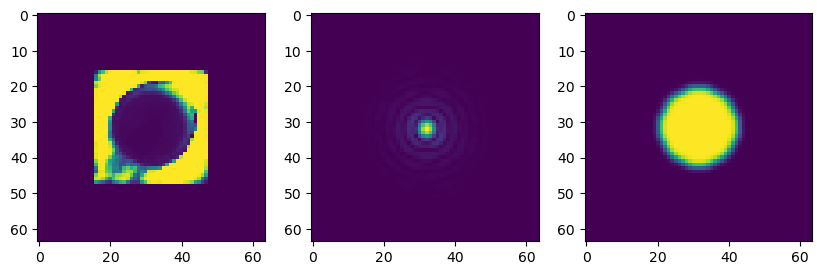

In [30]:
i = 14
fig, axs = plt.subplots(1, 3, figsize=(10,5))

axs[0].imshow(test_pred_cpu[i,0].abs())
axs[1].imshow(diff.to('cpu')[i,0])
axs[2].imshow(probe.to('cpu')[0,0].abs())

Going to double check whether or not the forward model is working as intended...

In [12]:
with torch.no_grad():
    test_pred_obj = loaded_model.forward_predict(diff, positions, probe, scaling)

In [13]:
test_pred_obj_cpu = test_pred_obj.to('cpu')

test_pred_obj_cpu.device, test_pred_obj_cpu.dtype

(device(type='cpu'), torch.complex64)

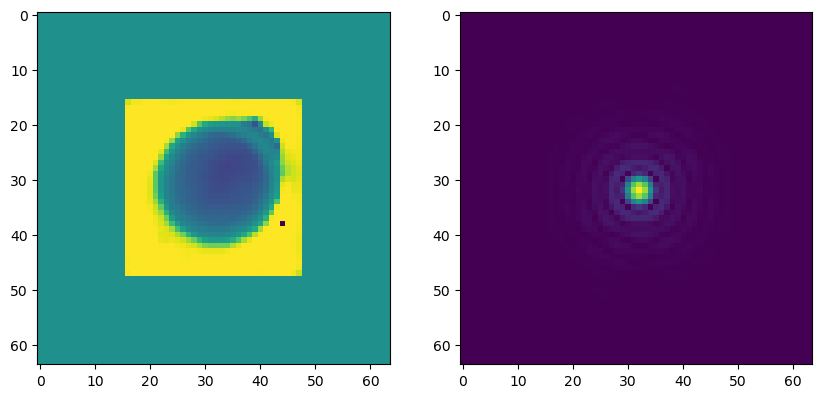

In [18]:
i = 4
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].imshow(test_pred_obj_cpu[i,0].angle())
axs[1].imshow(diff.to('cpu')[i,0])